# Using ShaTS with a Keras Model

Although the ShaTS library is implemented in PyTorch and requires it to function, it also supports models trained in Keras (including models saved in `.h5` format). This notebook provides an example of how to integrate a Keras model with ShaTS for xAI purposes.

This notebook is equivalent to [this one](../example_toy_dataset/example.ipynb). Therefore, all steps unrelated to the integration of the Keras model are omitted for clarity.


## 1. AD Framework Configuration

#### Imports and config

In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

import os
#This line is added for the GPU not to be used. If you would like to use it, delete it
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


2025-06-15 18:12:41.994517: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 18:12:42.001984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750003962.010197  871150 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750003962.012629  871150 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750003962.019227  871150 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1.1 Data preprocessing

#### Dataset creation

In [3]:
# Parámetros del dataset sintético
n_samples = 10000
n_features = 50
categorical_columns = [f'Cat{i}' for i in range(5)]
continuous_columns = [f'Cont{i}' for i in range(n_features - len(categorical_columns))]

# Generación de datos sintéticos
np.random.seed(42)
categorical_data = np.random.randint(0, 5, size=(n_samples, len(categorical_columns)))

# Generar datos aleatorios centrados en 0 para fluctuación
dataCont = np.random.randn(n_samples, len(continuous_columns))

# Crear un array para almacenar los resultados con fluctuación controlada
continuous_data = np.zeros_like(dataCont)

for i in range(n_samples):
    # Calcular el rango de la ventana móvil
    start = max(0, i - 10 + 1)
    # Calcular la media acumulada dentro de la ventana
    window_mean = np.mean(dataCont[start:i+1], axis=0)
    # Añadir el valor medio en lugar de la suma acumulada
    continuous_data[i] = window_mean

# Generación de etiquetas basadas en una función no lineal de las características
labels = pd.Series(np.zeros(n_samples))
for i in range(n_samples):
    #suma las continuous data pares y resta los impares
    linear_combination = 0
    for j in range(len(continuous_columns)):
        if j % 2 == 0:
            linear_combination += continuous_data[i, j]
        else:
            linear_combination -= continuous_data[i, j]
    
    if linear_combination > 0:
        labels[i] = 1

# Crear DataFrame sintético
data = pd.DataFrame(np.hstack([categorical_data, continuous_data]), columns=categorical_columns + continuous_columns)
data['Normal/Attack'] = labels
data['Index'] = data.index
data = data.drop(columns=['Normal/Attack'])

print(data.head())

   Cat0  Cat1  Cat2  Cat3  Cat4     Cont0     Cont1     Cont2     Cont3  \
0   3.0   4.0   2.0   4.0   4.0  1.752429 -0.291520 -0.350569 -1.869980   
1   1.0   2.0   2.0   2.0   4.0  1.076240  0.201538 -0.724296 -1.043338   
2   3.0   2.0   4.0   1.0   3.0  0.764186  0.087515 -0.490137 -0.653486   
3   1.0   3.0   4.0   0.0   3.0  0.065802  0.396573 -0.230036 -0.645557   
4   1.0   4.0   3.0   0.0   0.0  0.140822  0.349283 -0.561272 -0.435195   

      Cont4  ...    Cont36    Cont37    Cont38    Cont39    Cont40    Cont41  \
0  0.690073  ...  0.687049 -0.753650  0.507943  0.113100 -0.057752 -1.241423   
1  0.602920  ... -0.086847 -0.905164  0.185658  0.124826  0.707720 -0.559046   
2  0.562293  ... -0.506509 -0.410285  0.422424 -0.233332  0.393032 -0.310591   
3  0.637821  ... -0.476443 -0.136543  0.048090  0.212492  0.529242 -0.067564   
4  0.628435  ... -0.502941 -0.171857  0.340737  0.192653  0.409208 -0.052523   

     Cont42    Cont43    Cont44  Index  
0  0.153253  0.184957  0.10

In [4]:
# porcentaje de anomalías y trafico normal
anomaly_percentage = labels.value_counts(normalize=True)[1]
normal_percentage = labels.value_counts(normalize=True)[0]
print(f"Anomaly percentage: {anomaly_percentage:.2%}")
print(f"Normal percentage: {normal_percentage:.2%}")

Anomaly percentage: 49.69%
Normal percentage: 50.31%


#### Data preprocessing: Windowing

In [5]:
segment_size = 500
padding_size = 50
train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

In [6]:
train_data_list, val_data_list, test_data_list, padding_data_list = [], [], [], []
train_labels_list, val_labels_list, test_labels_list, padding_labels_list = [], [], [], []
train_indexes_list, val_indexes_list, test_indexes_list, padding_indexes_list = [], [], [], []

for i in range(0, len(data), segment_size):

    init = i
    end = min(i + segment_size, len(data))

    segment_indexes = data['Index'].iloc[init:end]
    
    segment_data = data.iloc[init:end]
    segment_labels = labels.iloc[init:end]
    
    train_split_index = int(train_percentage * len(segment_data))
    val_split_index = int((train_percentage + val_percentage) * len(segment_data))
    
    #TRAIN
    train_data_list.append(segment_data.iloc[:train_split_index])
    train_labels_list.append(segment_labels.iloc[:train_split_index])
    
    # Padding before VALIDATION
    padding_start = max(0, train_split_index - padding_size)
    padding_data_list.append(segment_data.iloc[padding_start:train_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start:train_split_index])
    
    # VALIDATION
    val_data_list.append(segment_data.iloc[train_split_index:val_split_index])
    val_labels_list.append(segment_labels.iloc[train_split_index:val_split_index])
    
    # Padding before TEST
    padding_start_val = max(0, val_split_index - padding_size)
    padding_end_val = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[padding_start_val:val_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start_val:val_split_index])
    
    # TEST
    test_data_list.append(segment_data.iloc[val_split_index:])
    test_labels_list.append(segment_labels.iloc[val_split_index:])
    
    # Padding before next SEGMENT
    padding_end = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[val_split_index:padding_end])
    padding_labels_list.append(segment_labels.iloc[val_split_index:padding_end])

    train_indexes_list.append(segment_indexes.iloc[:train_split_index])
    val_indexes_list.append(segment_indexes.iloc[train_split_index:val_split_index])
    test_indexes_list.append(segment_indexes.iloc[val_split_index:])


# Concatenate
train_data = pd.concat(train_data_list).reset_index(drop=True)
val_data = pd.concat(val_data_list).reset_index(drop=True)
test_data = pd.concat(test_data_list).reset_index(drop=True)
padding_data = pd.concat(padding_data_list).reset_index(drop=True)

train_labels = pd.concat(train_labels_list).reset_index(drop=True)
val_labels = pd.concat(val_labels_list).reset_index(drop=True)
test_labels = pd.concat(test_labels_list).reset_index(drop=True)
padding_labels = pd.concat(padding_labels_list).reset_index(drop=True)

train_indexes = pd.concat(train_indexes_list).reset_index(drop=True)
val_indexes = pd.concat(val_indexes_list).reset_index(drop=True)
test_indexes = pd.concat(test_indexes_list).reset_index(drop=True)


print(f'Train data shape: {train_data.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Train index shape: {train_indexes.shape}')
print()

print(f'Validation data shape: {val_data.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Validation index shape: {val_indexes.shape}')
print()

print(f'Test data shape: {test_data.shape}')
print(f'Test labels shape: {test_labels.shape}')
print(f'Test index shape: {test_indexes.shape}')
print()

x_train = train_data.to_numpy()
y_train = train_labels.to_numpy()
x_val = val_data.to_numpy()
y_val = val_labels.to_numpy()
x_test = test_data.to_numpy()
y_test = test_labels.to_numpy()

Train data shape: (7000, 51)
Train labels shape: (7000,)
Train index shape: (7000,)

Validation data shape: (1500, 51)
Validation labels shape: (1500,)
Validation index shape: (1500,)

Test data shape: (1500, 51)
Test labels shape: (1500,)
Test index shape: (1500,)



In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels, indexes, stride=1, window_size=10):

        self.x = data.to_numpy(dtype=np.float32)  
        self.labels = labels.to_numpy(dtype=np.float32)  
        self.labels = np.array([[1, 0] if label == 0 else [0, 1] for label in self.labels], dtype=np.float32)
        self.indexes = indexes.to_numpy(dtype=np.int32)  
        self.window_size = window_size
        self.stride = stride

        self.valid_idxs = self._preprocess_windows()
        self.n_idxs = len(self.valid_idxs)

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        item = {}
        item["given"] = torch.from_numpy(self.x[i:i + self.window_size]).to(torch.float32)
        item["label"] = torch.tensor(self.labels[i + self.window_size - 1], dtype=torch.float32).to(device)
        item["answer"] = torch.tensor(self.labels[i + self.window_size-1], dtype=torch.float32).to(device)
        item["indexes"] = self.indexes[i + self.window_size - 1]
        return item

    def _preprocess_windows(self):
        temp_valid_idxs = []
        total_windows = len(self.x) - self.window_size + 1
        print(f"Total windows: {total_windows}")
        
        for L in range(0, total_windows, self.stride):
            window_indices = self.indexes[L:L + self.window_size]
            
            if np.all(np.diff(window_indices) == 1):
                temp_valid_idxs.append(L)
        
        print(f"Valid windows: {len(temp_valid_idxs)}")
        return np.array(temp_valid_idxs, dtype=np.int32)

#### Data preprocessing: Removing 0-variance features, identifying continuous and categorical features

In [8]:
zero_variance_columns = train_data.columns[train_data.nunique() <= 1].tolist()

train_data_trans = train_data.drop(columns=['Index'])
val_data_trans = val_data.drop(columns=['Index'])
test_data_trans = test_data.drop(columns=['Index'])

train_data_trans = train_data_trans.drop(columns=zero_variance_columns)
val_data_trans = val_data_trans.drop(columns=zero_variance_columns)
test_data_trans = test_data_trans.drop(columns=zero_variance_columns)

categorical_columns = [col for col in train_data_trans.columns if train_data_trans[col].nunique() < 10]
continuous_columns = [col for col in train_data_trans.columns if col not in categorical_columns]

print(f"Zero variance columns: {len(zero_variance_columns)}: {zero_variance_columns}")
print(f'Categorical columns: {len(categorical_columns)}: {categorical_columns}')
print(f'Continuous columns: {len(continuous_columns)}: {continuous_columns}')

Zero variance columns: 0: []
Categorical columns: 5: ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4']
Continuous columns: 45: ['Cont0', 'Cont1', 'Cont2', 'Cont3', 'Cont4', 'Cont5', 'Cont6', 'Cont7', 'Cont8', 'Cont9', 'Cont10', 'Cont11', 'Cont12', 'Cont13', 'Cont14', 'Cont15', 'Cont16', 'Cont17', 'Cont18', 'Cont19', 'Cont20', 'Cont21', 'Cont22', 'Cont23', 'Cont24', 'Cont25', 'Cont26', 'Cont27', 'Cont28', 'Cont29', 'Cont30', 'Cont31', 'Cont32', 'Cont33', 'Cont34', 'Cont35', 'Cont36', 'Cont37', 'Cont38', 'Cont39', 'Cont40', 'Cont41', 'Cont42', 'Cont43', 'Cont44']


In [9]:
for col in categorical_columns:
    train_data_trans[col] = train_data_trans[col].astype('category')
    val_data_trans[col] = val_data_trans[col].astype('category')
    test_data_trans[col] = test_data_trans[col].astype('category')

In [10]:
#Standardize continuous columns and one-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

pipeline.fit(train_data_trans)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Cont0', 'Cont1', 'Cont2',
                                                   'Cont3', 'Cont4', 'Cont5',
                                                   'Cont6', 'Cont7', 'Cont8',
                                                   'Cont9', 'Cont10', 'Cont11',
                                                   'Cont12', 'Cont13', 'Cont14',
                                                   'Cont15', 'Cont16', 'Cont17',
                                                   'Cont18', 'Cont19', 'Cont20',
                                                   'Cont21', 'Cont22', 'Cont23',
                                                   'Cont24', 'Cont25', 'Cont26',
                                                   'Cont27', 'Cont28', 'Cont29', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Cat0', 'Cat1', 'Cat2',
                                                   'Cat3', 'Cat4'])]))])

In [11]:
x_train_trans = pipeline.transform(train_data_trans)
x_val_trans = pipeline.transform(val_data_trans)
x_test_trans = pipeline.transform(test_data_trans)

In [12]:
categorical_feature_names = pipeline.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(categorical_columns)
all_feature_names = continuous_columns + list(categorical_feature_names)

x_train_df = pd.DataFrame(x_train_trans, columns=all_feature_names)
x_val_df = pd.DataFrame(x_val_trans, columns=all_feature_names)
x_test_df = pd.DataFrame(x_test_trans, columns=all_feature_names)

x_train_df.head()

,Cont0,Cont1,Cont2,Cont3,Cont4,Cont5,Cont6,Cont7,Cont8,Cont9,...,Cat3_0.0,Cat3_1.0,Cat3_2.0,Cat3_3.0,Cat3_4.0,Cat4_0.0,Cat4_1.0,Cat4_2.0,Cat4_3.0,Cat4_4.0
0,5.433623,-0.886929,-1.134649,-5.940902,2.222566,-2.155915,0.470116,-1.038447,-1.509999,-0.392417,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3.347292,0.660716,-2.332001,-3.310100,1.944515,-1.471800,1.774260,-0.392639,-4.014728,1.125772,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.384473,0.302814,-1.581799,-2.069389,1.814896,0.241395,-1.243241,0.910149,-4.579530,1.070694,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.229663,1.272906,-0.748483,-2.044156,2.055861,-0.619802,-0.840824,0.864100,-3.246244,0.132328,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.461131,1.124468,-1.809701,-1.374675,2.025916,-1.636106,-1.435433,2.000459,-2.726757,0.721066,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
print(f"Train data transformed shape: {x_train_df.shape}")
print(f"Validation data transformed shape: {x_val_df.shape}")
print(f"Test data transformed shape: {x_test_df.shape}")
variable_names = all_feature_names
print("Variables names after transformation:")
print(variable_names)

Train data transformed shape: (7000, 70)
Validation data transformed shape: (1500, 70)
Test data transformed shape: (1500, 70)
Variables names after transformation:
['Cont0', 'Cont1', 'Cont2', 'Cont3', 'Cont4', 'Cont5', 'Cont6', 'Cont7', 'Cont8', 'Cont9', 'Cont10', 'Cont11', 'Cont12', 'Cont13', 'Cont14', 'Cont15', 'Cont16', 'Cont17', 'Cont18', 'Cont19', 'Cont20', 'Cont21', 'Cont22', 'Cont23', 'Cont24', 'Cont25', 'Cont26', 'Cont27', 'Cont28', 'Cont29', 'Cont30', 'Cont31', 'Cont32', 'Cont33', 'Cont34', 'Cont35', 'Cont36', 'Cont37', 'Cont38', 'Cont39', 'Cont40', 'Cont41', 'Cont42', 'Cont43', 'Cont44', 'Cat0_0.0', 'Cat0_1.0', 'Cat0_2.0', 'Cat0_3.0', 'Cat0_4.0', 'Cat1_0.0', 'Cat1_1.0', 'Cat1_2.0', 'Cat1_3.0', 'Cat1_4.0', 'Cat2_0.0', 'Cat2_1.0', 'Cat2_2.0', 'Cat2_3.0', 'Cat2_4.0', 'Cat3_0.0', 'Cat3_1.0', 'Cat3_2.0', 'Cat3_3.0', 'Cat3_4.0', 'Cat4_0.0', 'Cat4_1.0', 'Cat4_2.0', 'Cat4_3.0', 'Cat4_4.0']


In [14]:
trainDataset = TimeSeriesDataset(data=pd.DataFrame(x_train_df) , labels=train_labels, indexes=train_indexes , stride=1, window_size=10)
valDataset = TimeSeriesDataset(data=pd.DataFrame(x_val_df) , labels=val_labels, indexes=val_indexes , stride=1, window_size=10)
testDataset = TimeSeriesDataset(data=pd.DataFrame(x_test_df) , labels=test_labels, indexes=test_indexes , stride=1, window_size=10)

Total windows: 6991
Valid windows: 6820
Total windows: 1491
Valid windows: 1320
Total windows: 1491
Valid windows: 1320


In [15]:
#For each original variable, store the indices of the generated variables in all_feature_names

variables_map = {}

#Continuous variables
for v in continuous_columns:
    variables_map[v] = [all_feature_names.index(v)]  

#Categorical variables
encoder = pipeline.named_steps["preprocessor"].transformers_[1][1] 
for v, categories in zip(categorical_columns, encoder.categories_):
    encoded_names = [f"{v}_{category}" for category in categories]
    indexes = [all_feature_names.index(name) for name in encoded_names]
    variables_map[v] = indexes

### 1.2 AD Model Training and Evaluation

#### AD Model definition

In this step, instead of a Pytorch model, a Keras model is trained.

In [16]:
def build_keras_model(input_dim, hidden_dim=32, num_layers=2, dropout=0.2, num_classes=2):
    model = Sequential()
    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        if i == 0:
            model.add(Bidirectional(LSTM(hidden_dim, return_sequences=return_sequences), input_shape=(None, input_dim)))
        else:
            model.add(Bidirectional(LSTM(hidden_dim, return_sequences=return_sequences)))
        model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [17]:
def convert_dataset_to_keras(dataset):
    X, y = [], []
    for i in range(len(dataset)):
        item = dataset[i]
        X.append(item["given"].cpu().numpy())
        y.append(np.argmax(item["label"].cpu().numpy()))
    X = np.array(X)  # (n_samples, window_size, features)
    y = to_categorical(y, num_classes=2)
    return X, y

x_train_np, y_train_np = convert_dataset_to_keras(trainDataset)
x_val_np, y_val_np = convert_dataset_to_keras(valDataset)

#### Training/Loading the AD model

In [ ]:
input_dim = trainDataset[0]['given'].shape[1]
hidden_dim = 32
num_layers = 2
dropout = 0.2
num_classes = 2
learning_rate = 0.001
num_epochs = 5
batch_size = 64
alpha = 1
gamma = 2


keras_model = build_keras_model(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

keras_model.fit(
    x_train_np, y_train_np,
    validation_data=(x_val_np, y_val_np),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=0
)

# Guardar el modelo entrenado para luego usarlo en inferencia con PyTorch
keras_model.save('KerasModel.h5')

# Keras-Torch connection

This step is crucial for ShaTS to propperly work. The keras model is "wrapped" in a function where the desired result is converted to torch.tensor type

In [25]:
from tensorflow.keras.models import load_model

keras_model = load_model('KerasModel.h5')

def keras_model_probs(model):
    def f(data):    
        # Si el batch size es 1, añade dimensión
        if len(data.shape) == 2:
            data = data.unsqueeze(0)
        data_np = data.cpu().numpy()  # Convertir tensor a numpy
        probs = model.predict(data_np, verbose=0)
        return torch.tensor(probs)
    return f

model_wrapper = keras_model_probs(keras_model)

#### Model evaluation

Test Accuracy: 0.9121 | Precision: 0.9131 | Recall: 0.9116 | F1-score: 0.9120



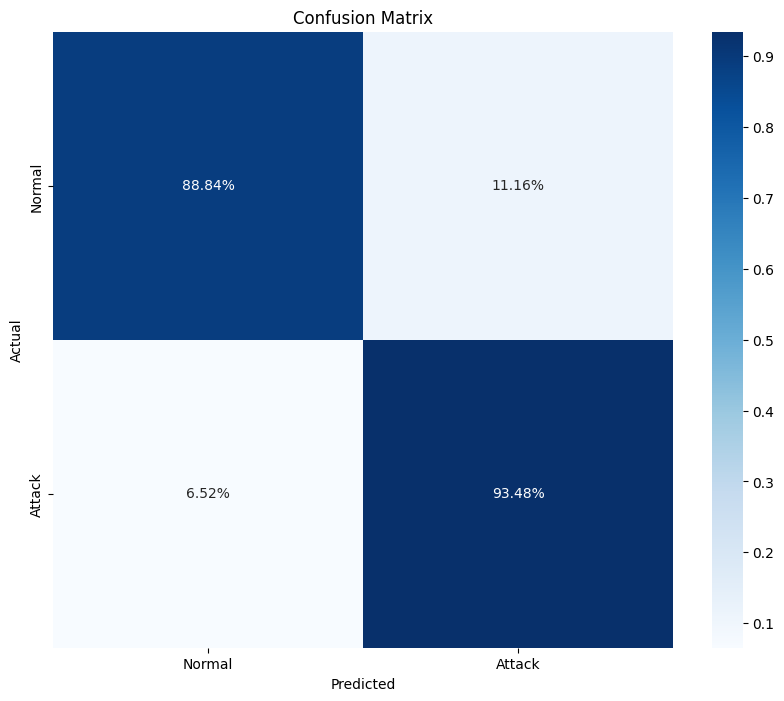

In [26]:
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for data_batch in test_loader:
        x_batch = data_batch["given"].to(device)
        y_batch = data_batch["label"].to(device)
        outputs = model_wrapper(x_batch)
        y_batch_indices = torch.argmax(y_batch, dim=1)
        predicted = torch.argmax(outputs, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch_indices.cpu().numpy())

all_preds = np.array(all_preds).reshape(-1)
all_labels = np.array(all_labels).reshape(-1)

accuracy = (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f'Test Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}\n')

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Creation of a wrapper of the model that compute the probs of each class

## 2 - ShaTS xAI Component

#### Configuration

In [21]:
import os
import sys
sys.path.append(os.path.abspath("../../src"))

import shats
from shats.grouping import TimeGroupingStrategy, MultifeaturesGroupingStrategy, FeaturesGroupingStrategy

#### Creation of the background dataset and selection of the windows that will be explained 

In [22]:
random_samples = random.sample(range(len(trainDataset)), 100)
support = [trainDataset[idx]['given'] for idx in random_samples]

begin = 798 #begining instant to be explained
end = begin + 100 #end instant to be explained
test = [testDataset[idx]['given'] for idx in range(begin, end)]


### 2.1 - ShaTS Temporal Strategy

Processing item 100/100 (100.00%)

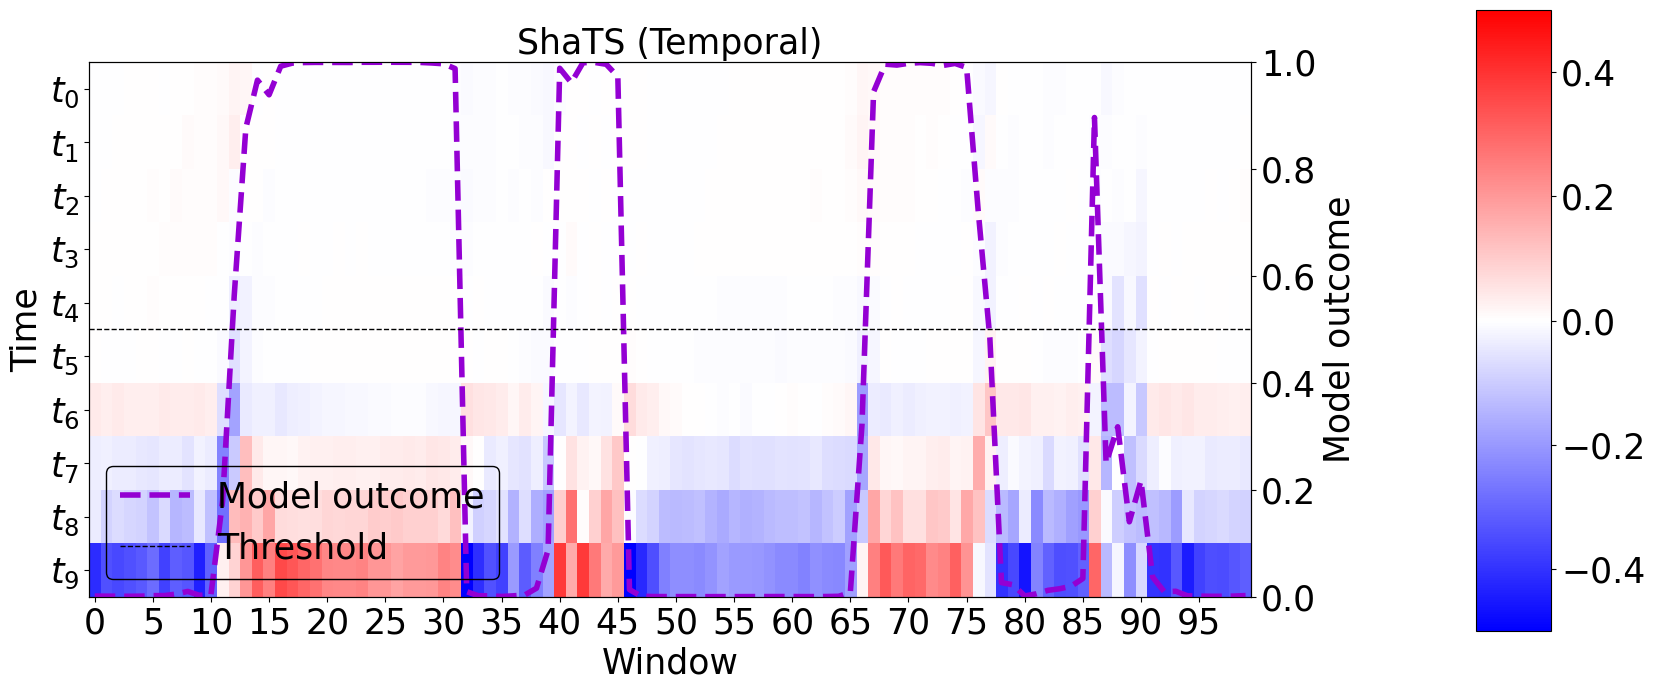

In [27]:
shapley_class = shats.FastShaTS(model_wrapper, 
                               support_dataset=support ,
                               grouping_strategy= TimeGroupingStrategy(names=["$t_0$", "$t_1$", "$t_2$", "$t_3$", "$t_4$", "$t_5$", "$t_6$", "$t_7$", "$t_8$", "$t_9$"])
                               )

shapley_values = shapley_class.compute(test)
shapley_class.plot(shapley_values, test, class_to_explain=0)

### 2.2 - ShaTS Feature Strategy

Processing item 10/10 (100.00%)

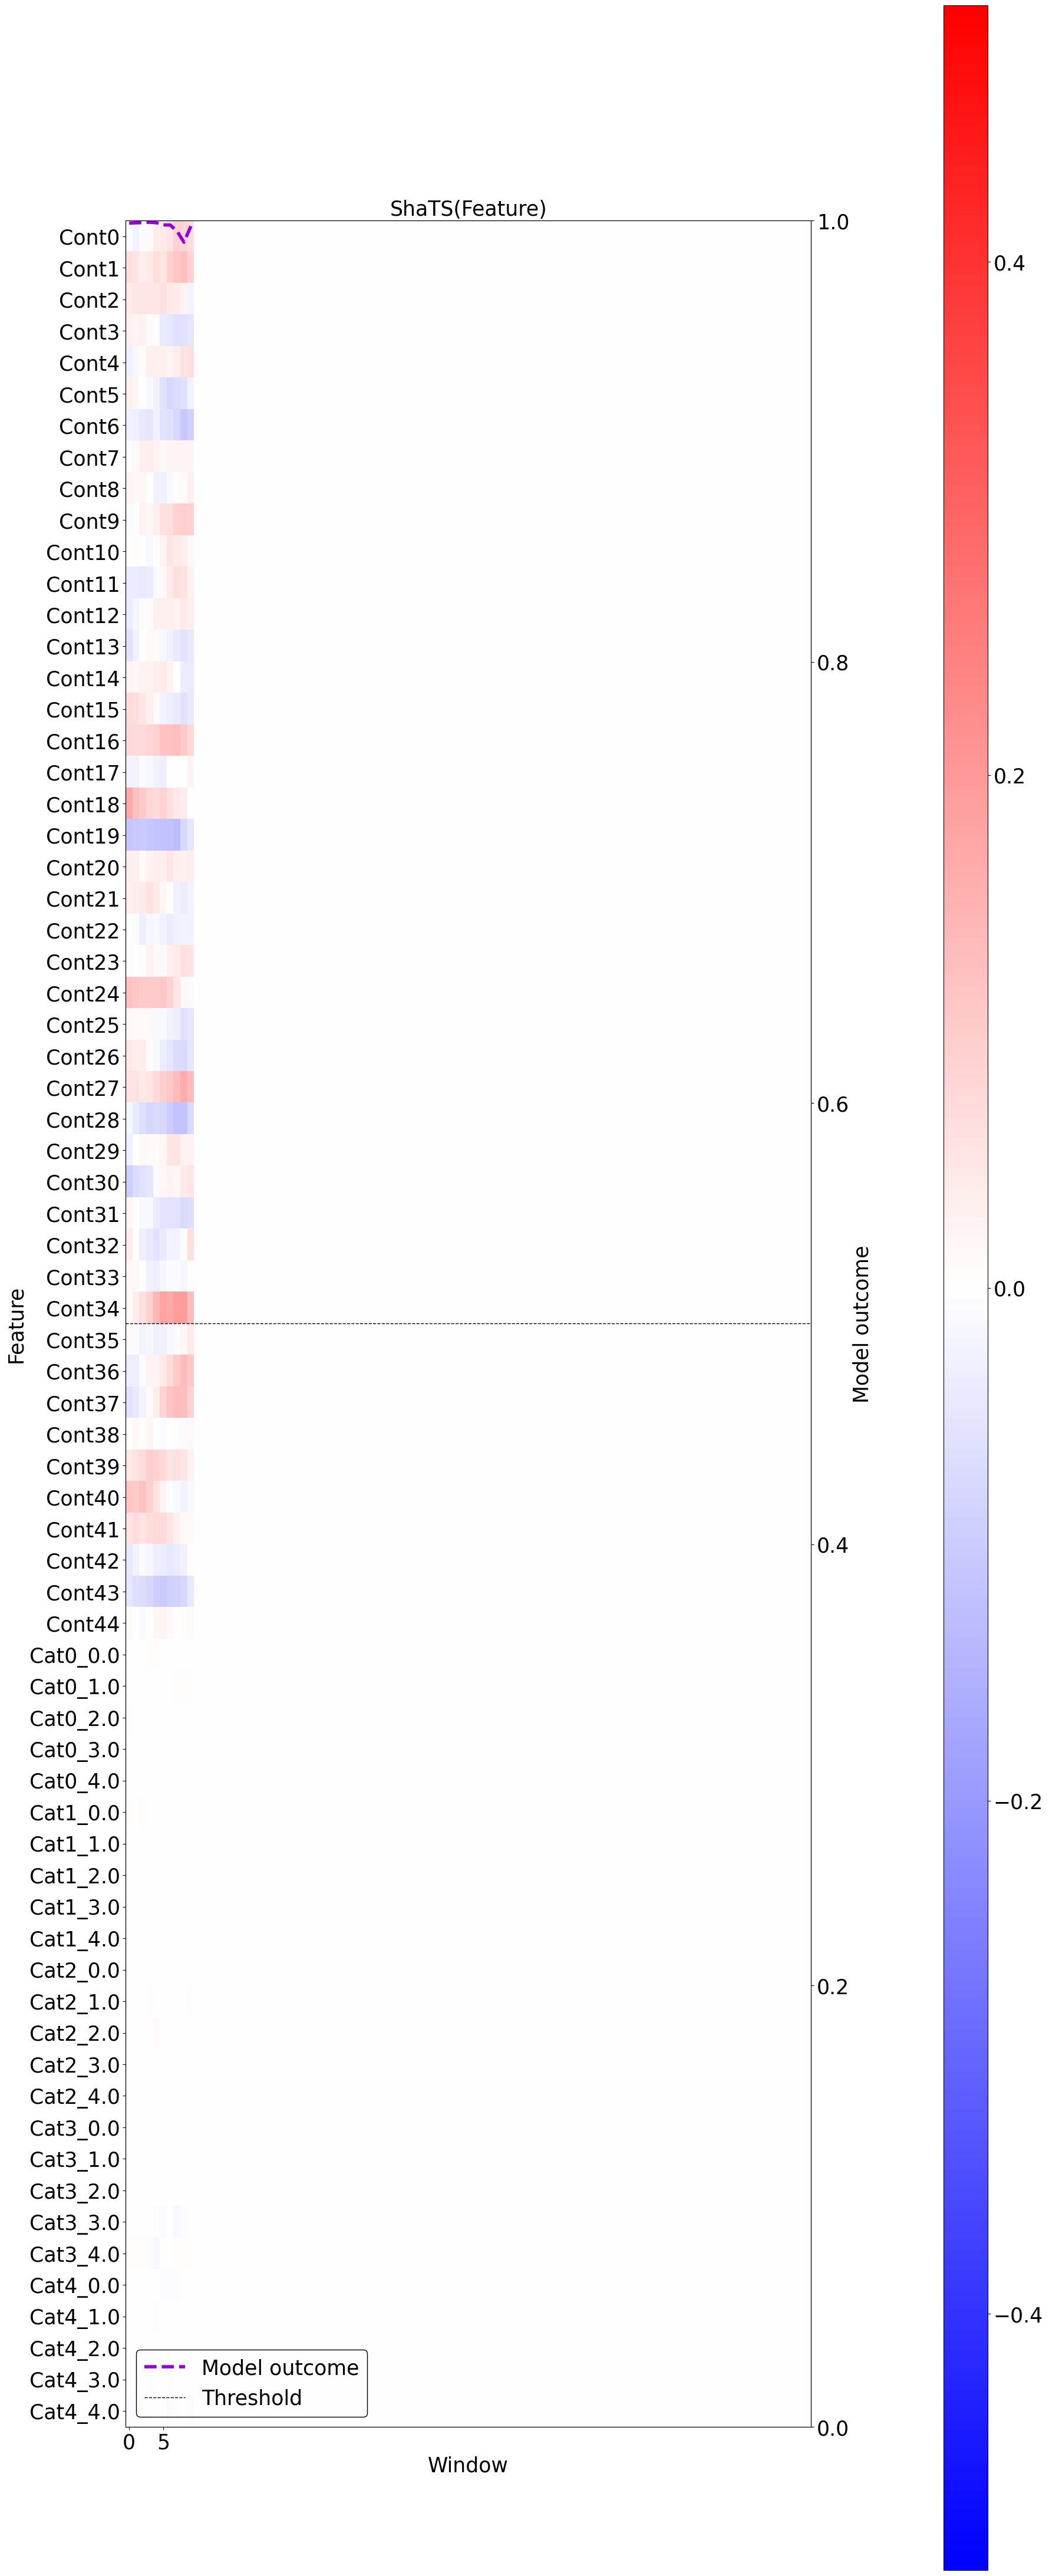

In [32]:
shapley_class = shats.FastShaTS(model_wrapper, 
                               support_dataset=support ,
                               grouping_strategy= FeaturesGroupingStrategy(names=variable_names),
                               )

shapley_values = shapley_class.compute(test[0:10])
shapley_class.plot(shapley_values, test, class_to_explain=1)

### 2.3 - ShaTS MultiFeature Strategy

In [33]:
index_grouping = [[],[],[],[]]   

for i in range(len(all_feature_names)):
    index_grouping[i % 4].append(i)
print(f"Process: {index_grouping}")

type_grouping = [[],[]]   

for i in range(len(all_feature_names)):
    if i < len(continuous_columns):
        type_grouping[0].append(i)
    else:
        type_grouping[1].append(i)

print(f"Process2: {type_grouping}")

Process: [[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68], [1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69], [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66], [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67]]
Process2: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]]


Processing item 100/100 (100.00%)

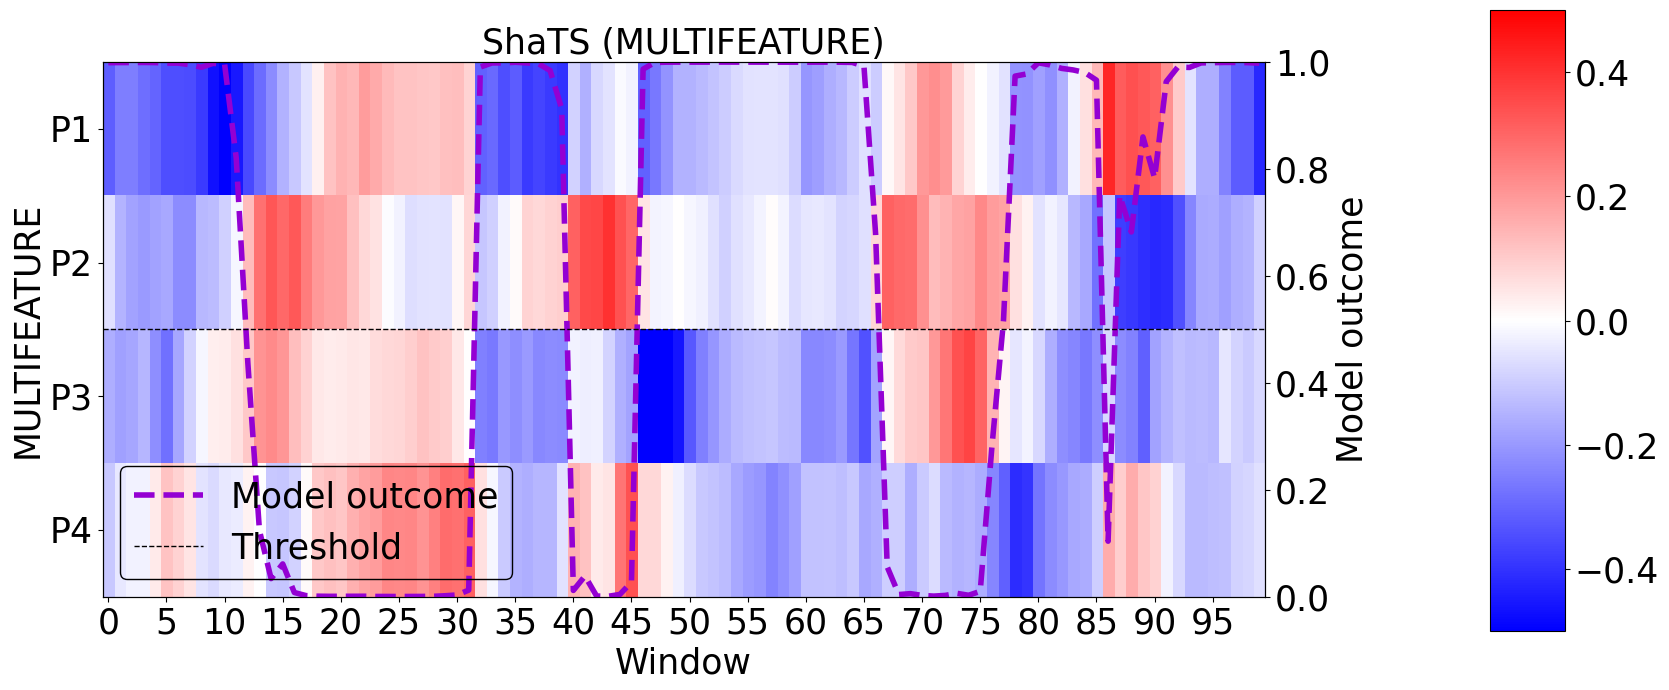

In [34]:
shapley_class = shats.ApproShaTS(model_wrapper = model_wrapper,
                               support_dataset=support ,
                               grouping_strategy= MultifeaturesGroupingStrategy(custom_groups=index_grouping, names= ["P1", "P2", "P3", "P4"]),
                               )

shapley_values = shapley_class.compute(test)

shapley_class.plot(shapley_values, test, class_to_explain=1)

Processing item 100/100 (100.00%)

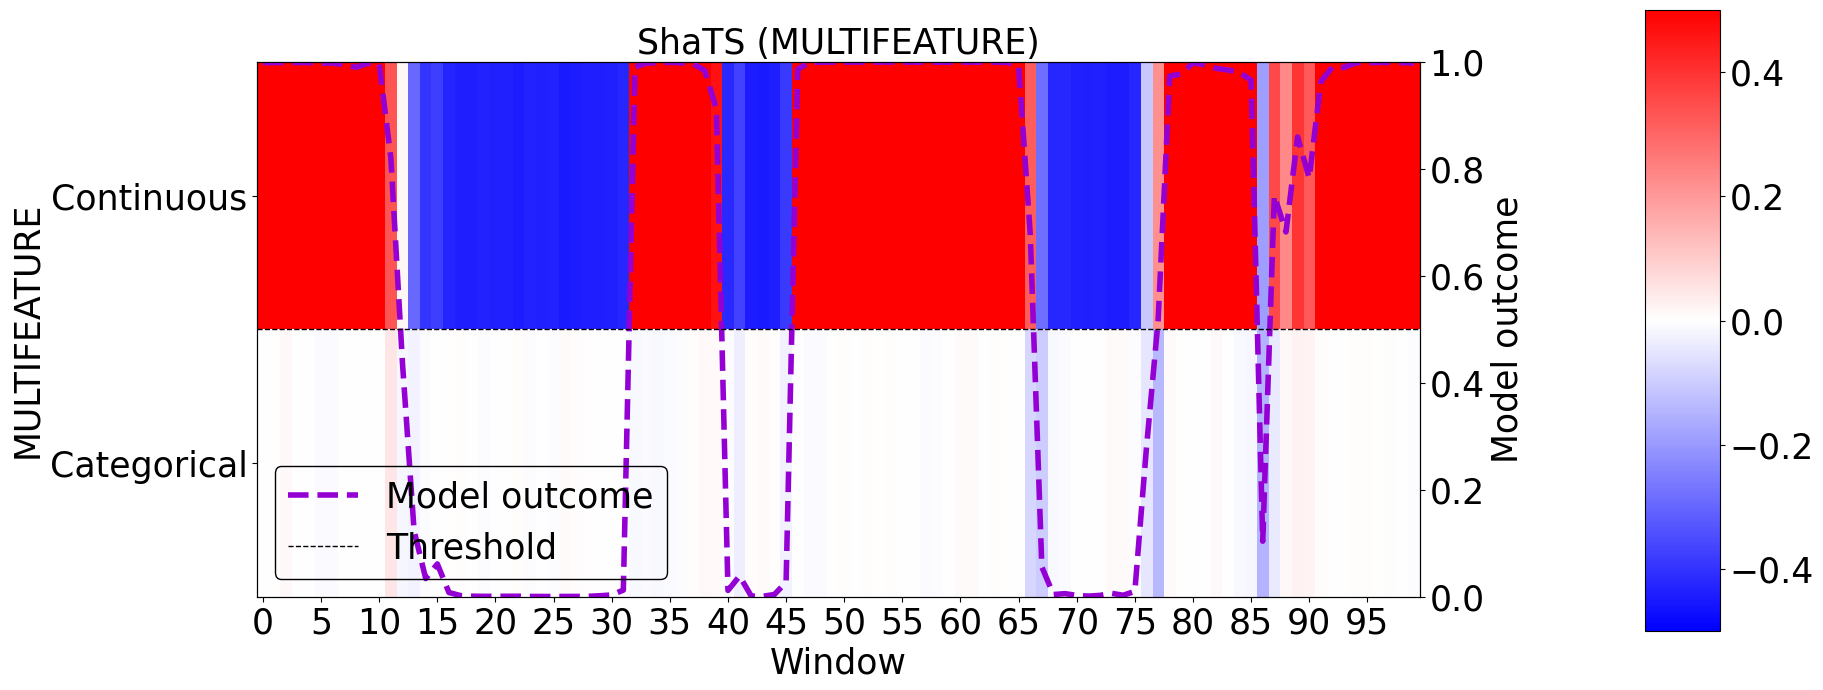

In [35]:
shapley_class = shats.FastShaTS(model_wrapper = model_wrapper,
                               support_dataset=support ,
                               grouping_strategy= MultifeaturesGroupingStrategy(custom_groups=type_grouping, names= ["Continuous", "Categorical"]),
                               )

shapley_values = shapley_class.compute(test)

shapley_class.plot(shapley_values, test, class_to_explain=1)